In [35]:
import scanpy as sc
import pandas as pd
import numpy as np
# import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from anndata import AnnData
import scipy.sparse as sp

import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Load the data
sample_id = "IMMUNEX001"
adata = sc.read_10x_h5(f"/home/mounim/rawdata/IMMUNEX/OUTPUT/Visium_NSCLC_{sample_id}/outs/binned_outputs/square_016um/filtered_feature_bc_matrix.h5")
adata.raw = adata
adata.uns['sample_id'] = sample_id
adata


/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 170351 × 18536
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'sample_id'

image loaded


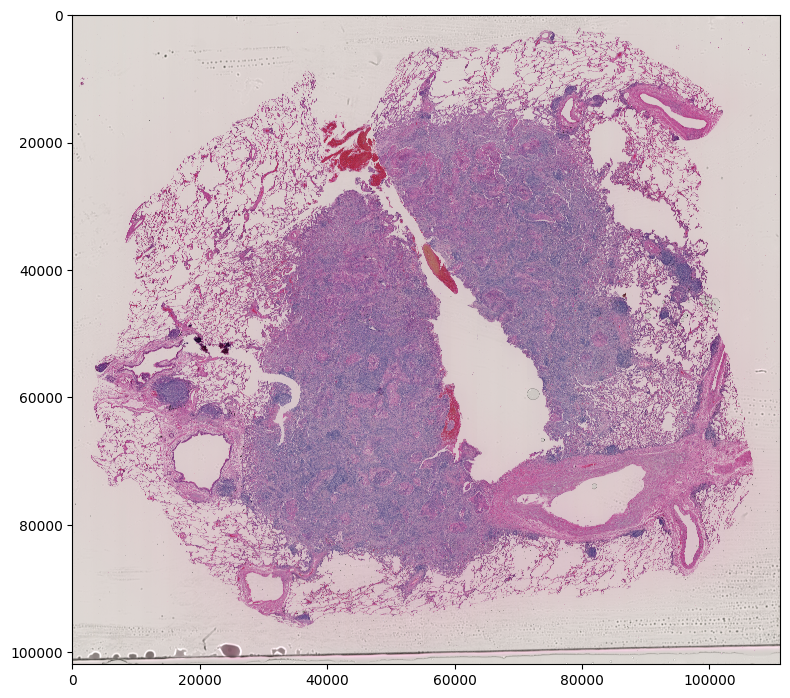

In [3]:
from tifffile import imread, imwrite

tiff_path = "/home/mounim/rawdata/IMMUNEX/PJ2410310_250214/IMAGE/HE_nanozoomer_tif/IMMUNEX012_Visium_HE_x40_z0.tif"

img = imread(tiff_path)
print('image loaded')

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.tight_layout()
plt.show()

In [7]:
spatial

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
s_016um_00107_00066-1,1,107,66,50756.729258,81052.559994
s_016um_00158_00414-1,1,158,414,54549.075128,56739.865815
s_016um_00126_00213-1,1,126,213,52180.773160,70780.782226
s_016um_00290_00411-1,1,290,411,63781.787941,57034.525366
s_016um_00082_00292-1,1,82,292,49153.513113,65225.808212
...,...,...,...,...,...
s_016um_00001_00157-1,1,1,157,43399.714879,74618.074287
s_016um_00404_00257-1,1,404,257,71658.151605,67881.334555
s_016um_00412_00400-1,1,412,400,72309.865957,57882.426588
s_016um_00361_00190-1,1,361,190,68606.686039,72540.958498


In [36]:
import pandas as pd

# Load spatial coordinates
spatial_path = "/home/mounim/rawdata/IMMUNEX/OUTPUT/Visium_NSCLC_IMMUNEX001/outs/binned_outputs/square_016um/spatial/tissue_positions.parquet"
spatial = pd.read_parquet(spatial_path)
spatial.set_index("barcode", inplace=True)

# Align with adata
spatial = spatial.loc[adata.obs_names]

spatial[["x", "y"]] = spatial[["pxl_row_in_fullres","pxl_col_in_fullres"]]
# Inject into obsm
adata.obsm["spatial"] = spatial[["x", "y"]].to_numpy()


<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

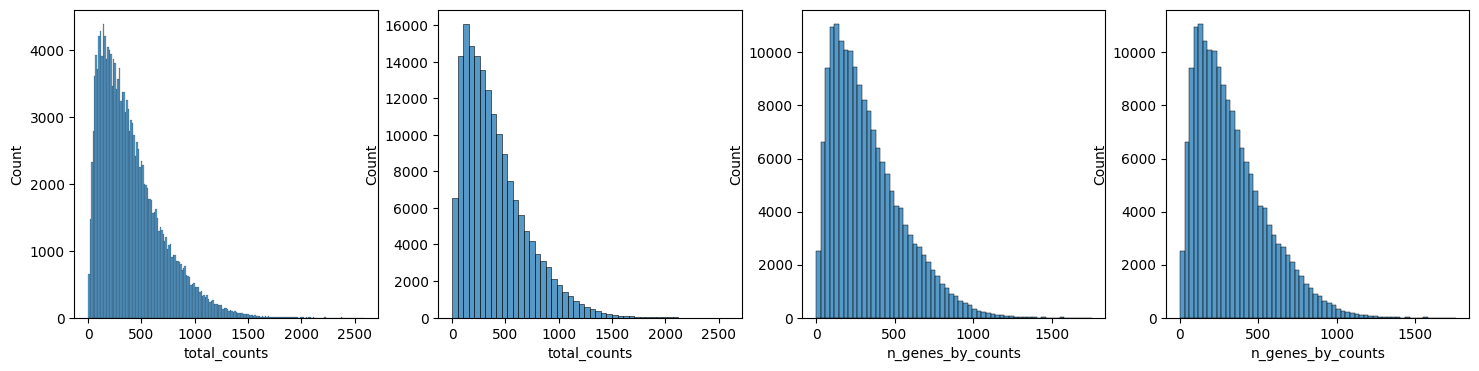

In [37]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(18, 4))
sns.histplot(adata.obs["total_counts"], ax=axs[0])
sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 50000], bins=50, ax=axs[1])
sns.histplot(adata.obs["n_genes_by_counts"], bins=60, ax=axs[2])
sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 5000], bins=60, ax=axs[3])


In [38]:
sc.pp.filter_cells(adata, min_counts=5)
sc.pp.filter_cells(adata, max_counts=1000)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
sc.pp.filter_genes(adata, min_cells=10)
adata


/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 162540 × 17683
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_id'
    obsm: 'spatial'

In [39]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)


In [40]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 162540 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_id', 'log1p', 'hvg'
    obsm: 'spatial'

/home/mounim/miniconda3/envs/enact/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


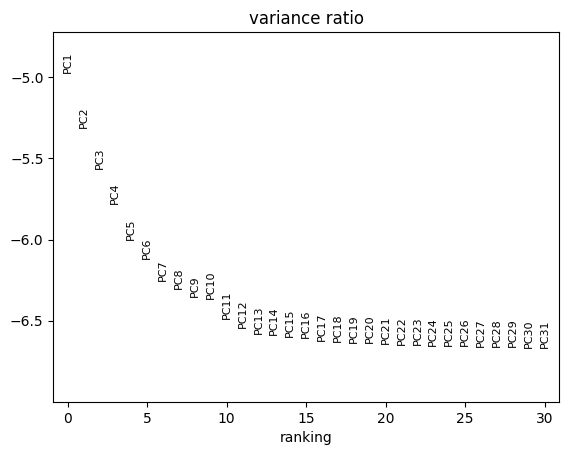

In [41]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)


In [42]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=12)


In [46]:
sc.tl.leiden(adata, resolution=0.5)  

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [47]:
adata.obs['leiden'].nunique()

9

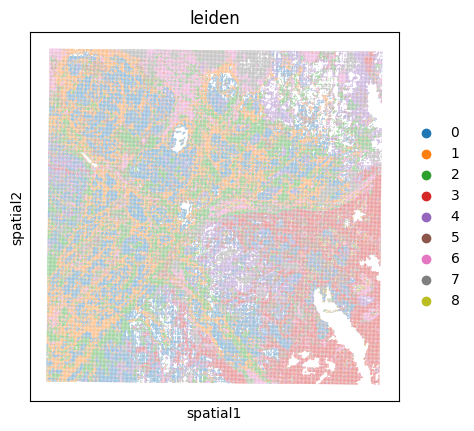

In [48]:
import scanpy as sc

sc.pl.spatial(
    adata,
    color='leiden',
    spot_size=50,
    show=True
)


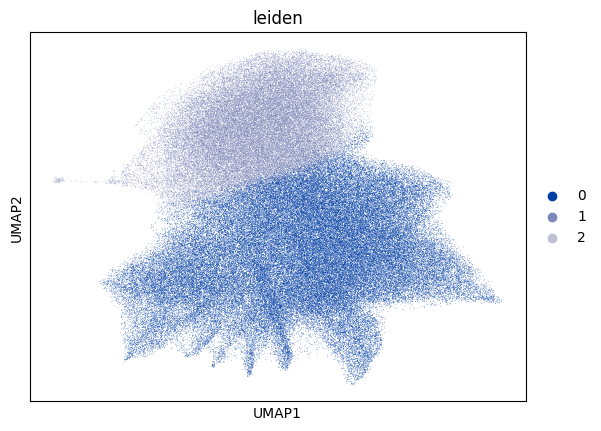

In [31]:
import scanpy as sc

# Run DE analysis between leiden clusters
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='t-test',  # or 'wilcoxon' (default), 'logreg'
    use_raw=False,
    n_genes=100  # top N genes per cluster
)


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import geopandas as gpd
from shapely.geometry import Point, MultiPolygon
from shapely.ops import unary_union

# --- Step 1: Prepare spatial + cluster data ---
# Get spot XY coordinates and Leiden labels
coords = adata.obsm['spatial']  # shape: (n_spots, 2)
labels = adata.obs['leiden'].astype(str)  # ensure string

# Create GeoDataFrame: one point per spot
gdf = gpd.GeoDataFrame({'cluster': labels}, geometry=[Point(x, y) for x, y in coords])
gdf.set_crs(epsg=3857, inplace=True)  # or None if you're in pixel units



,cluster,geometry
s_016um_00107_00066-1,1,POINT (81052.56 50756.729)
s_016um_00158_00414-1,0,POINT (56739.866 54549.075)
s_016um_00126_00213-1,0,POINT (70780.782 52180.773)
s_016um_00082_00292-1,0,POINT (65225.808 49153.513)
s_016um_00329_00125-1,0,POINT (77067.762 66326.069)
...,...,...
s_016um_00376_00030-1,0,POINT (83744.26 69553.115)
s_016um_00001_00157-1,0,POINT (74618.074 43399.715)
s_016um_00404_00257-1,0,POINT (67881.335 71658.152)
s_016um_00361_00190-1,1,POINT (72540.958 68606.686)


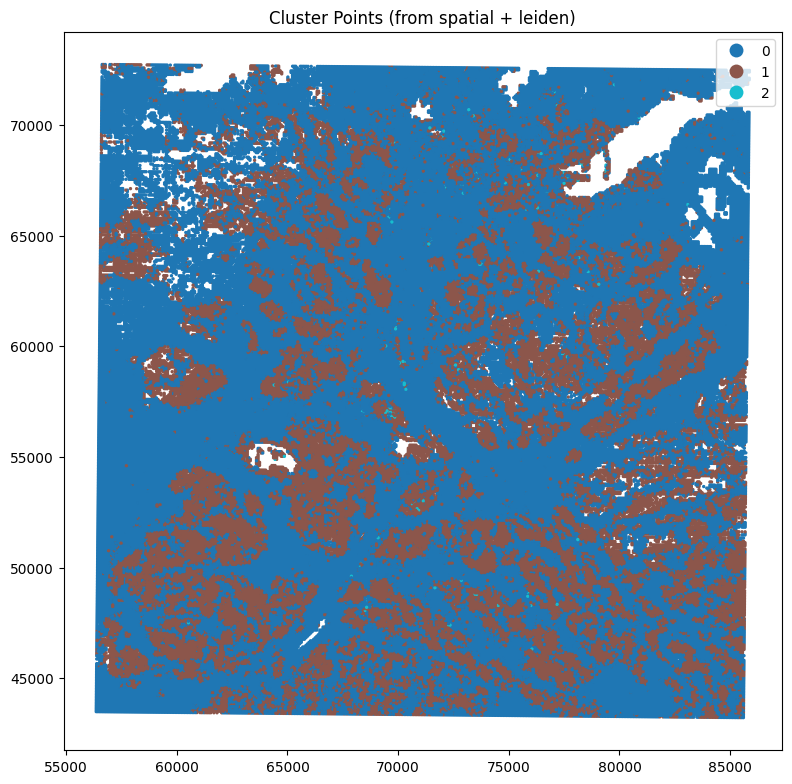

In [35]:
# Visualize raw cluster points
fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, column='cluster', markersize=2, legend=True)
ax.set_title("Cluster Points (from spatial + leiden)")
plt.tight_layout()
plt.savefig("step1_cluster_points.png", dpi=200)
plt.show()


In [34]:

# --- Step 2: Create expanded cluster shapes ---
buffer_radius = 30  # pixels of expansion
cluster_shapes = {}

for cluster in tqdm(sorted(gdf['cluster'].unique())):
    cluster_points = gdf[gdf['cluster'] == cluster]
    cluster_union = unary_union(cluster_points.buffer(buffer_radius))
    cluster_shapes[cluster] = cluster_union


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:45<00:00, 15.15s/it]


/tmp/ipykernel_1398959/580797775.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/tmp/ipykernel_1398959/580797775.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


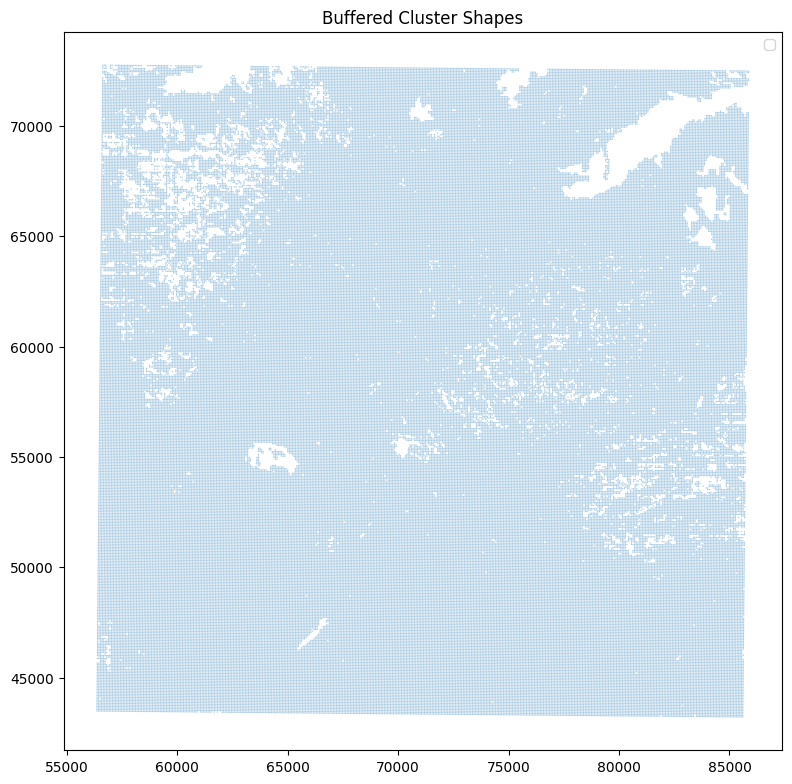

In [36]:
# Visualize expanded cluster shapes
fig, ax = plt.subplots(figsize=(8, 8))
for cluster, shape in cluster_shapes.items():
    gpd.GeoSeries([shape]).plot(ax=ax, alpha=0.4, label=f"Cluster {cluster}")
ax.set_title("Buffered Cluster Shapes")
ax.legend()
plt.tight_layout()
plt.savefig("step2_cluster_polygons.png", dpi=200)
plt.show()

In [ ]:

# --- Step 3: Generate masks for each cluster ---
height, width = img.shape[:2]
masks = {}

for cluster, shape in cluster_shapes.items():
    mask = np.zeros((height, width), dtype=np.uint8)
    polygons = shape.geoms if isinstance(shape, MultiPolygon) else [shape]
    for poly in tqdm(polygons):
        coords = np.array(poly.exterior.coords).round().astype(np.int32)
        cv2.fillPoly(mask, [coords], 255)
    masks[cluster] = mask

    # Visualize mask
    plt.figure(figsize=(6, 6))
    plt.imshow(mask, cmap='gray')
    plt.title(f"Cluster {cluster} - Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"step3_cluster_{cluster}_mask.png", dpi=150)
    plt.show()

In [ ]:

# --- Step 4: Apply masks to original image ---
cluster_images = {}

for cluster, mask in masks.items():
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    # Save image
    out_path = f"cluster_{cluster}_masked.png"
    cv2.imwrite(out_path, cv2.cvtColor(masked_img, cv2.COLOR_RGB2BGR))

    cluster_images[cluster] = masked_img

    print(f"Saved: {out_path}")